# 2. Train U-Net

## Summary

* split images and masks to train and test sets of 80:20 ratio
* load unet and train
* calculate sensitivty for predicted masks that have at least 5 pixel overlap with the ground truth mask

In [22]:
import numpy as np

#EDIT HERE##############################
datafolder='processeddata'
weightsfolder='modelweights'
noduleimages=np.load(datafolder+"/noduleimages.npy")
nodulemasks=np.load(datafolder+"/nodulemasks.npy")

########################################


from glob import glob
import matplotlib.pyplot as plt
import os
from keras.models import Sequential,load_model,Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, SpatialDropout2D
from keras.layers import Input, merge, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import pandas as pd
from keras.callbacks import ModelCheckpoint
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

K.set_image_dim_ordering('th') 

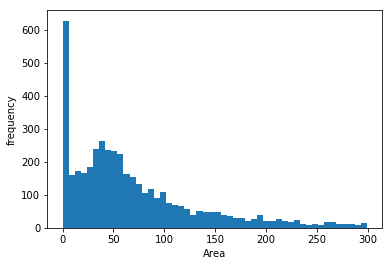

In [3]:
nodulesize=[np.sum(mask) for mask in nodulemasks]
plt.hist([nod for nod in nodulesize if nod<300],bins=50)
plt.xlabel("Area")
plt.ylabel("frequency")
plt.show()
#remove samples with nodulesize<25, which is ~radius=2.8
#filteredindicies=[i for i in range(len(nodulesize)) if nodulesize[i]>25]
#noduleimages=noduleimages[filteredindicies]
#nodulemasks=nodulemasks[filteredindicies]

In [4]:
noduleimages=noduleimages.reshape(noduleimages.shape[0],1,512,512)
nodulemasks=nodulemasks.reshape(nodulemasks.shape[0],1,512,512)
imagestrain, imagestest, maskstrain, maskstest = train_test_split(noduleimages,nodulemasks,test_size=.20)

In [8]:
#Code sourced from https://www.kaggle.com/c/data-science-bowl-2017#tutorial
smooth = 1.0
width = 32

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet_model():
    inputs = Input((1,512, 512))
    conv1 = Conv2D(width, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = BatchNormalization(axis = 1)(conv1)
    conv1 = Conv2D(width, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(width*2, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = BatchNormalization(axis = 1)(conv2)
    conv2 = Conv2D(width*2, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(width*4, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = BatchNormalization(axis = 1)(conv3)
    conv3 = Conv2D(width*4, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(width*8, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = BatchNormalization(axis = 1)(conv4)
    conv4 = Conv2D(width*8, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(width*16, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = BatchNormalization(axis = 1)(conv5)
    conv5 = Conv2D(width*16, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = SpatialDropout2D(0.35)(up6)
    conv6 = Conv2D(width*8, 3, 3, activation='relu', border_mode='same')(conv6)
    conv6 = Conv2D(width*8, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = SpatialDropout2D(0.35)(up7)
    conv7 = Conv2D(width*4, 3, 3, activation='relu', border_mode='same')(conv7)
    conv7 = Conv2D(width*4, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = SpatialDropout2D(0.35)(up8)
    conv8 = Conv2D(width*2, 3, 3, activation='relu', border_mode='same')(conv8)
    conv8 = Conv2D(width*2, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = SpatialDropout2D(0.35)(up9)
    conv9 = Conv2D(width, 3, 3, activation='relu', border_mode='same')(conv9)
    conv9 = Conv2D(width, 3, 3, activation='relu', border_mode='same')(conv9)
    conv10 = Conv2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    return model

In [7]:
# Train model on dataset with only nodules
model=unet_model()
filepath=weightsfolder+"/unet-weights-improvement.hdf5"
#model.load_weights(filepath)

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True)
history=model.fit(imagestrain, maskstrain, batch_size=4, nb_epoch=20, verbose=1, shuffle=True,
              callbacks=[checkpoint],validation_data=(imagestest,maskstest))
#history=model.fit_generator(generator(batch_size=batchsize), steps_per_epoch=len(nonzeroindex)/batchsize-batchsize*11, nb_epoch=1, callbacks=callbacks_list)

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  from ipykernel import kernelapp as app
c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3

Train on 4018 samples, validate on 1005 samples
Epoch 1/20
4018/4018 [==============================] - 598s - loss: -0.0830 - dice_coef: 0.0830 - val_loss: -0.2151 - val_dice_coef: 0.2151
Epoch 2/20
4018/4018 [==============================] - 582s - loss: -0.2627 - dice_coef: 0.2627 - val_loss: -0.3493 - val_dice_coef: 0.3493
Epoch 3/20
4018/4018 [==============================] - 581s - loss: -0.3634 - dice_coef: 0.3634 - val_loss: -0.4280 - val_dice_coef: 0.4280
Epoch 4/20
4018/4018 [==============================] - 582s - loss: -0.4369 - dice_coef: 0.4369 - val_loss: -0.4941 - val_dice_coef: 0.4941
Epoch 5/20
4018/4018 [==============================] - 577s - loss: -0.4768 - dice_coef: 0.4768 - val_loss: -0.4864 - val_dice_coef: 0.4864
Epoch 6/20
4018/4018 [==============================] - 576s - loss: -0.5089 - dice_coef: 0.5089 - val_loss: -0.5356 - val_dice_coef: 0.5356
Epoch 7/20
4018/4018 [==============================] - 569s - loss: -0.5345 - dice_coef: 0.5345 - val_los

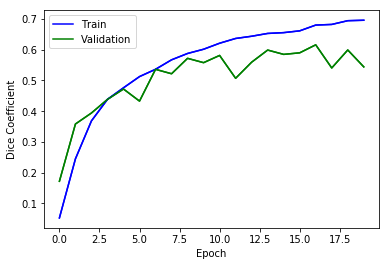

In [13]:
plt.plot(history.history['dice_coef'], color='b')
plt.plot(history.history['val_dice_coef'], color='g')
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.legend(["Train", "Validation"])
plt.show()

In [8]:
model.evaluate(imagestest,maskstest, batch_size=4)

1004/1005 [============================>.] - ETA: 0s

[-0.67809058924145371, 0.67809058924145371]

In [31]:
num_test=imagestest.shape[0]
imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)
for i in range(num_test):
    imgs_mask_test[i] = model.predict([imagestest[i:i+1]], verbose=0)[0]

sumoverlap=[]
for i in range(num_test):
    sumoverlap.append(np.sum(maskstest[i,0]*imgs_mask_test[i,0]))

#nodulemasks
len([ov for ov in sumoverlap if ov>1])/len(sumoverlap)

0.6069651741293532

Predicted


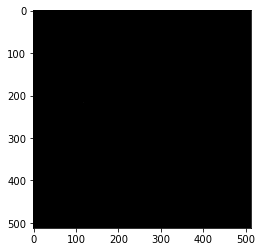

Ground Truth


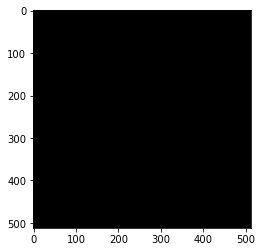

Image


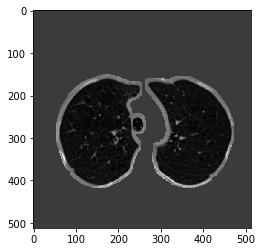

In [32]:
#Visualize prediction mask

index=47
print("Predicted")
plt.imshow(imgs_mask_test[index,0], cmap="gray")
plt.show()
print("Ground Truth")
plt.imshow(maskstest[index,0],cmap="gray")
plt.show()
print("Image")
plt.imshow(imagestest[index,0], cmap="gray")
plt.show()